In [1]:
%%markdown
# The Latte Line of Sydney
## 1. Problem statement
### What is the Latte Line
Major cities around the world demonstrate a diversity in neighbourhoods in terms of lifestyle, income, social status and ethnic background of people, low- and high density areas, and so on.
In developed countries neighbourhoods are usually mixed based on the above criteria: ideally there are no ghettoes and no exclusive upperclass areas, however, the difference between disctricts can be quite apparent.
In case of Sydney people are talking about a 'latte line' which divides the city to 2 parts, the prosperous North-East and the less attractive South-West. 
As the 'latte line' name suggests, this distinction - while could have been established on hard statistical facts, such as property prices, average income, university addmission rate of high school students - is based on observed or assumed difference of life style.

Can we support or debunk the 'latte line' theory with the help of data science?

# The Latte Line of Sydney
## 1. Problem statement
### What is the Latte Line
Major cities around the world demonstrate a diversity in neighbourhoods in terms of lifestyle, income, social status and ethnic background of people, low- and high density areas, and so on.
In developed countries neighbourhoods are usually mixed based on the above criteria: ideally there are no ghettoes and no exclusive upperclass areas, however, the difference between disctricts can be quite apparent.
In case of Sydney people are talking about a 'latte line' which divides the city to 2 parts, the prosperous North-East and the less attractive South-West. 
As the 'latte line' name suggests, this distinction - while could have been established on hard statistical facts, such as property prices, average income, university addmission rate of high school students - is based on observed or assumed difference of life style.

Can we support or debunk the 'latte line' theory with the help of data science?


In [2]:
%%markdown
## 2. Use of data to evaluate the 'latte line'
The following data sets would come handy:
1. A list of neighborhoods of Sydney
2. Population size of neighbourhoods
3. Foursquare API with venues

For practical reasons the list of neighborhoods will be taken from the Australian Bureau of Statistics, since we can get population size (number of residents) at the same granularity.
Neighbourhoods are going to be assigned with their lat/log coordinates.
Neighbourhoods will be labeled on which side they are of the latte line. For the geographical identification of the latte line we use a report of the Australian national news agency, abc.com.au:
https://www.abc.net.au/news/2019-12-17/sydneys-latte-line-divides-job-and-housing-opportunities/11803706

Foursquare API will be used to fetch venues for the analysed geographical areas.
Since in this particular case life style is the subject of analysis the number of venues will be harmonised on population density: venue count * 1000 / (residents / sqms).

The goal of the analysis is building a model to predict if a neighbourhood based on the life style represented by venues belongs to the up or down side of the latte line with at least 75% accuracy.

Setting the accuracy treshold is arbitrary. While we cannot expect foursquare data to make a deinite distinction between latte/non-latte regions, if it is closer to 50% than 100% we may question whether the latte line model reflect a difference in life style.

## 2. Use of data to evaluate the 'latte line'
The following data sets would come handy:
1. A list of neighborhoods of Sydney
2. Population size of neighbourhoods
3. Foursquare API with venues

For practical reasons the list of neighborhoods will be taken from the Australian Bureau of Statistics, since we can get population size (number of residents) at the same granularity.
Neighbourhoods are going to be assigned with their lat/log coordinates.
Neighbourhoods will be labeled on which side they are of the latte line. For the geographical identification of the latte line we use a report of the Australian national news agency, abc.com.au:
https://www.abc.net.au/news/2019-12-17/sydneys-latte-line-divides-job-and-housing-opportunities/11803706

Foursquare API will be used to fetch venues for the analysed geographical areas.
Since in this particular case life style is the subject of analysis the number of venues will be harmonised on population density: venue count * 1000 / (residents / sqms).

The goal of the analysis is building a model to predict if a neighbourhood based on the life style represented by venues belongs to the up or down side of the latte line with at least 75% accuracy.

Setting the accuracy treshold is arbitrary. While we cannot expect foursquare data to make a deinite distinction between latte/non-latte regions, if it is closer to 50% than 100% we may question whether the latte line model reflect a difference in life style.


In [3]:
%%markdown
# 3. Defining the latte line
Using the link in the previous section we can identify the suggested location of the theoretical straight line.
Note: a map is a 2D projection of a 3D planet, thus using lat/long coordinates and linear regression is methodoligically not entirely correct. However, considering the arbitrariness of the latte line, this error does not impact the success of labeling.
    
SW: -34.001321, 151.235472
    
NE: -33.55000, 150.662457
    
Using y = ax + b with both data pair would give us the value of a and b

# 3. Defining the latte line
Using the link in the previous section we can identify the suggested location of the theoretical straight line.
Note: a map is a 2D projection of a 3D planet, thus using lat/long coordinates and linear regression is methodoligically not entirely correct. However, considering the arbitrariness of the latte line, this error does not impact the success of labeling.
    
SW: -34.001321, 151.235472
    
NE: -33.55000, 150.662457
    
Using y = ax + b with both data pair would give us the value of a and b


In [4]:
import folium
import pandas as pd
import os
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import json # library to handle JSON files
print('Libraries imported.')
import requests

Libraries imported.


In [5]:
%%markdown
Let's put the 'Latte Line' on the map!
It starts on SE at Botany Bay, just below the Airport, then passes by Tempe and Burwood, crosses Parramatta, divides the north between Bella Vista and Blacktown and ends around Richmond.

All beaches, the CBD and the hills are on one side, all the industrial areas and the suburbs far from the CBD are on the other side.

Let's put the 'Latte Line' on the map!
It starts on SE at Botany Bay, just below the Airport, then passes by Tempe and Burwood, crosses Parramatta, divides the north between Bella Vista and Blacktown and ends around Richmond.

All beaches, the CBD and the hills are on one side, all the industrial areas and the suburbs far from the CBD are on the other side.


In [6]:
coordinates = [[-34.001321, 151.235472],[-33.55000, 150.662457]]

latitude=-33.800000
longitude=151.00000
# create map of Sydney using latitude and longitude values
#f = folium.Figure(width=2000, height=2000)
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=11)
#my_PolyLine=folium.PolyLine(locations=coordinates,weight=5)
folium.PolyLine(coordinates).add_to(map_sydney)

#f.add_child(map_sydney)
#display(f)
display(map_sydney)

In [7]:
%%markdown
Let's create a function which can determine based on coordinates whether a location is above or under the line!
In this exercise we do not concern on 2D projection, just use a straigth line between 2 dots.

Let's create a function which can determine based on coordinates whether a location is above or under the line!
In this exercise we do not concern on 2D projection, just use a straigth line between 2 dots.


In [8]:
start_lat = -34.001321
start_long =  151.235472
end_lat = -33.55000
end_long = 150.662457

left = -34.001321 - (-33.55000)
right = 151.235472 - 150.662457
a = right/left
print("Value of a:")
print(a)
b1 = 151.235472 - (a * -34.001321)
b2 =  150.662457- (a * -33.55000)
if b1 != b2:
    print("Calculation error")
    end
print("Value of b:")
print(b1)

Value of a:
-1.2696395691758149
Value of b:
108.0660494541514


In [9]:
%%markdown
Now we can evaluate the neighbourhoods, if lat >= (long - b) / a then the suburb is above or on the latte line, otherwise below.

Checking with Bankstown and Castle Hill, using approximate lat/long values

Bankstown: -33.916168, 151.033490 #should be below the line, thus false

Castle Hill: -33.729117, 151.005955 #should be above the line, thus true

Now we can evaluate the neighbourhoods, if lat >= (long - b) / a then the suburb is above or on the latte line, otherwise below.

Checking with Bankstown and Castle Hill, using approximate lat/long values

Bankstown: -33.916168, 151.033490 #should be below the line, thus false

Castle Hill: -33.729117, 151.005955 #should be above the line, thus true


In [10]:
def getLatte(lat, long):
    a = -1.2696395691758149
    b = 108.0660494541514
    print(a * float(lat) + b)
    if (lat >= (long - b) / a):
    
        return True
    else:
        return False

In [11]:
Bankstown = getLatte(-33.916168, 151.033490)
Bankstown

151.12735838176596


False

In [12]:
Blacktown = getLatte(-33.7402, 150.86500)
Blacktown

150.90394244605721


False

In [13]:
Castle_Hill = getLatte(-33.729117, 151.005955)
Castle_Hill

150.88987103071204


True

In [15]:
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=11.5)
folium.PolyLine(coordinates,  color='brown').add_to(map_sydney)
folium.CircleMarker(
        [-33.7402, 150.86500],
        radius=5,
        popup="Blacktown",
        color='yellow',
        fill=True,
        fill_opacity=0.7).add_to(map_sydney)
folium.CircleMarker(
        [-33.729117, 151.005955],
        radius=5,
        popup="Castle Hill",
        color='brown',
        fill=True,
        fill_opacity=0.7).add_to(map_sydney)
folium.PolyLine(coordinates, color='green').add_to(map_sydney)
display(map_sydney)

In [16]:
%%markdown
Our geographical latte labeling function is verified.

Our geographical latte labeling function is verified.


In [17]:
%%markdown
## Load statistical data and list of suburbs

Neighbourhood and population data comes from the Australian Statistical Bureau, 2016 census (abs.gov.au)
1. Population data of New South Wales on suburb level
2. Suburb dictionary

These are downloaded from the ABS data centre and imported to the platform manually.

The list of suburbs is from a csv file downloaded from the NSW goverment's website.

## Load statistical data and list of suburbs

Neighbourhood and population data comes from the Australian Statistical Bureau, 2016 census (abs.gov.au)
1. Population data of New South Wales on suburb level
2. Suburb dictionary

These are downloaded from the ABS data centre and imported to the platform manually.

The list of suburbs is from a csv file downloaded from the NSW goverment's website.


In [18]:
df_data_1 = pd.read_csv("C:/Users/1/coursera/capstone/census-population.csv")
#df_data_1 = pd.read_csv("C:/Users/1/coursera/capstone/census-pop-local-gov.csv")
df_data_1.head()

,SSC_CODE_2016,Tot_P_M,Tot_P_F,Tot_P_P,Age_0_4_yr_M,Age_0_4_yr_F,Age_0_4_yr_P,Age_5_14_yr_M,Age_5_14_yr_F,Age_5_14_yr_P,...,High_yr_schl_comp_Yr_8_belw_P,High_yr_schl_comp_D_n_g_sch_M,High_yr_schl_comp_D_n_g_sch_F,High_yr_schl_comp_D_n_g_sch_P,Count_psns_occ_priv_dwgs_M,Count_psns_occ_priv_dwgs_F,Count_psns_occ_priv_dwgs_P,Count_Persons_other_dwgs_M,Count_Persons_other_dwgs_F,Count_Persons_other_dwgs_P
0,SSC10001,12,12,22,0,0,0,0,0,0,...,0,0,0,0,9,6,21,0,3,4
1,SSC10002,2076,2177,4253,108,109,214,258,277,537,...,195,28,43,69,2034,2141,4175,44,37,79
2,SSC10003,2542,2838,5373,156,149,306,268,261,529,...,217,10,23,36,2338,2625,4962,164,184,355
3,SSC10004,535,579,1109,30,26,58,95,123,222,...,26,0,0,0,506,554,1056,15,17,38
4,SSC10005,13,7,22,0,0,0,0,0,0,...,0,0,0,0,13,9,24,0,0,0


In [19]:
df_data_2 = pd.read_csv("C:/Users/1/coursera/capstone/ssc_codes.csv")
df_data_2.head()

,ASGS_Structure,Census_Code_2016,ASGS_Code_2016,Census_Name_2016,Area sqkm
0,AUS,036,36,AUSTRALIA,7.688126e+06
1,CED,CED101,101,Banks,4.944600e+01
2,CED,CED102,102,Barton,3.964660e+01
3,CED,CED103,103,Bennelong,5.860520e+01
4,CED,CED104,104,Berowra,7.496359e+02


In [20]:
%%markdown
Let's get rid of the data we do not need for the analysis

Let's get rid of the data we do not need for the analysis


In [21]:
df_pop = df_data_1[['SSC_CODE_2016','Tot_P_M']]
#df_pop = df_data_1[['LGA_CODE_2016','Tot_P_M']]
df_pop.head()

,SSC_CODE_2016,Tot_P_M
0,SSC10001,12
1,SSC10002,2076
2,SSC10003,2542
3,SSC10004,535
4,SSC10005,13


In [22]:
df_sub_dict = df_data_2[['Census_Code_2016', 'Census_Name_2016',  'Area sqkm']]
df_sub_dict.head()

,Census_Code_2016,Census_Name_2016,Area sqkm
0,036,AUSTRALIA,7.688126e+06
1,CED101,Banks,4.944600e+01
2,CED102,Barton,3.964660e+01
3,CED103,Bennelong,5.860520e+01
4,CED104,Berowra,7.496359e+02


In [23]:
%%markdown
Let's assign suburb names from the dictionary to the suburb dataframe. We can assume every code should have a value in dictionary, thus 'inner join' is appropriate. Note, if some suburbs get lost, our analysis will be still valid.

Let's assign suburb names from the dictionary to the suburb dataframe. We can assume every code should have a value in dictionary, thus 'inner join' is appropriate. Note, if some suburbs get lost, our analysis will be still valid.


In [24]:
df_suburbs = df_pop.join(df_sub_dict.set_index('Census_Code_2016'), on='SSC_CODE_2016', how='inner')
df_suburbs.head()

,SSC_CODE_2016,Tot_P_M,Census_Name_2016,Area sqkm
0,SSC10001,12,Aarons Pass,82.7639
1,SSC10002,2076,Abbotsbury,4.9788
2,SSC10003,2542,Abbotsford (NSW),1.0180
3,SSC10004,535,Abercrombie,2.9775
4,SSC10005,13,Abercrombie River,127.1701


In [25]:
df_suburbs

,SSC_CODE_2016,Tot_P_M,Census_Name_2016,Area sqkm
0,SSC10001,12,Aarons Pass,82.7639
1,SSC10002,2076,Abbotsbury,4.9788
2,SSC10003,2542,Abbotsford (NSW),1.0180
3,SSC10004,535,Abercrombie,2.9775
4,SSC10005,13,Abercrombie River,127.1701
...,...,...,...,...
4521,SSC14522,0,Yuraygir,40.0581
4522,SSC14523,35,Zara,10.4649
4523,SSC14524,5027,Zetland,0.8048
4524,SSC19494,7351,No usual address (NSW),0.0000


In [26]:
%%markdown
Let's remove (NSW), (A), (C)

Let's remove (NSW), (A), (C)


In [27]:
for i in range(0, len(df_suburbs)):
    nsw_index = df_suburbs.iloc[i][2].find(' (NSW)')
    if nsw_index > -1:
        df_suburbs.loc[i, 'Census_Name_2016'] = (df_suburbs.iloc[i][2])[0:nsw_index]
    nsw_index = df_suburbs.iloc[i][2].find(' (A)')
    if nsw_index > -1:
        df_suburbs.loc[i, 'Census_Name_2016'] = (df_suburbs.iloc[i][2])[0:nsw_index]
    nsw_index = df_suburbs.iloc[i][2].find(' (C)')
    if nsw_index > -1:
        df_suburbs.loc[i, 'Census_Name_2016'] = (df_suburbs.iloc[i][2])[0:nsw_index]
       

In [28]:
%%markdown
Let's check further parentheses

Let's check further parentheses


In [29]:
df_suburbs[df_suburbs['Census_Name_2016'].str.contains("\(")]

,SSC_CODE_2016,Tot_P_M,Census_Name_2016,Area sqkm
33,SSC10034,44,Alison (Central Coast - NSW),1.3958
34,SSC10035,43,Alison (Dungog - NSW),19.2707
122,SSC10123,28,Back Creek (Bland - NSW),449.7950
123,SSC10124,9,Back Creek (Gwydir - NSW),119.9514
124,SSC10125,13,Back Creek (Mid-Coast - NSW),31.5289
...,...,...,...,...
4395,SSC14396,129,Woodstock (Shoalhaven - NSW),19.5936
4479,SSC14480,3,Yarras (Bathurst Regional - NSW),13.4096
4480,SSC14481,31,Yarras (Port Macquarie-Hastings - NSW),76.6314
4501,SSC14502,517,Yellow Rock (Blue Mountains - NSW),18.8096


In [30]:
%%markdown
There are still some values. As there are no records from other states, the differentiation is made between NSW regions. 
Considerations: if we remove these added remarks, we may create false mathces to Sydney suburbs.
If we leave the remarks, we may lose some of the suburbs. Creating false matches would have a more negative impact since those could distort the features of the observed population.
Thus let's leave it as is.

Fetching the suburb list.

There are still some values. As there are no records from other states, the differentiation is made between NSW regions. 
Considerations: if we remove these added remarks, we may create false mathces to Sydney suburbs.
If we leave the remarks, we may lose some of the suburbs. Creating false matches would have a more negative impact since those could distort the features of the observed population.
Thus let's leave it as is.

Fetching the suburb list.


In [31]:
df_data_3 = pd.read_csv("C:/Users/1/coursera/capstone/suburb-list.csv")
#df_data_3 = pd.read_csv("C:/Users/1/coursera/capstone/council-list.csv")
df_data_3.head()

,Suburb
0,Abbotsbury
1,Abbotsford
2,Acacia Gardens
3,Agnes Banks
4,Airds


In [32]:
%%markdown
Let's merge with the statistical bureau data, and check the size again

Let's merge with the statistical bureau data, and check the size again


In [33]:
df_sydney_suburbs = df_data_3.join(df_suburbs.set_index('Census_Name_2016'), on='Suburb', how='inner')
#df_sydney_suburbs = df_data_3.join(df_suburbs.set_index('Census_Name_2016'), on='council', how='inner')
df_sydney_suburbs.head()


,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm
0,Abbotsbury,SSC10002,2076,4.9788
1,Abbotsford,SSC10003,2542,1.0180
2,Acacia Gardens,SSC10014,1898,1.0013
3,Agnes Banks,SSC10021,472,15.4750
4,Airds,SSC10022,1333,2.3808


In [34]:
df_sydney_suburbs

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm
0,Abbotsbury,SSC10002,2076,4.9788
1,Abbotsford,SSC10003,2542,1.0180
2,Acacia Gardens,SSC10014,1898,1.0013
3,Agnes Banks,SSC10021,472,15.4750
4,Airds,SSC10022,1333,2.3808
...,...,...,...,...
664,Yagoona,SSC14453,8999,4.6180
665,Yarrawarrah,SSC14485,1334,1.2438
666,Yennora,SSC14506,804,2.7387
667,Yowie Bay,SSC14519,1497,1.2045


In [35]:
df_sydney_suburbs = df_sydney_suburbs.dropna()
df_sydney_suburbs.reset_index(drop=True)

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm
0,Abbotsbury,SSC10002,2076,4.9788
1,Abbotsford,SSC10003,2542,1.0180
2,Acacia Gardens,SSC10014,1898,1.0013
3,Agnes Banks,SSC10021,472,15.4750
4,Airds,SSC10022,1333,2.3808
...,...,...,...,...
644,Yagoona,SSC14453,8999,4.6180
645,Yarrawarrah,SSC14485,1334,1.2438
646,Yennora,SSC14506,804,2.7387
647,Yowie Bay,SSC14519,1497,1.2045


In [36]:
%%markdown
## Assign latitude and longitude columns to the data set

## Assign latitude and longitude columns to the data set


In [37]:
df_sydney_suburbs['lat'] = "0"
df_sydney_suburbs['long'] = "0"
df_sydney_suburbs.head()                  

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long
0,Abbotsbury,SSC10002,2076,4.9788,0,0
1,Abbotsford,SSC10003,2542,1.0180,0,0
2,Acacia Gardens,SSC10014,1898,1.0013,0,0
3,Agnes Banks,SSC10021,472,15.4750,0,0
4,Airds,SSC10022,1333,2.3808,0,0


In [38]:
df_sydney_suburbs.tail()  

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long
664,Yagoona,SSC14453,8999,4.6180,0,0
665,Yarrawarrah,SSC14485,1334,1.2438,0,0
666,Yennora,SSC14506,804,2.7387,0,0
667,Yowie Bay,SSC14519,1497,1.2045,0,0
668,Zetland,SSC14524,5027,0.8048,0,0


In [39]:
%%markdown
Let's define a geolocator function

Let's define a geolocator function


In [40]:
def geo_suburb(address):
    try:
        geolocator = Nominatim(user_agent="not_me")
        location = geolocator.geocode(address)
        #if location is None :
        #    return 0, 0
        return location.latitude, location.longitude
    except:
        geo_suburb(address)

In [45]:
#def fetcher(df_sydney_suburbs):
    try:
        for i in range(0, len(df_sydney_suburbs)):
            #print(str(i) + ": " + df_sydney_suburbs.iat[i, 0])
            if (float(df_sydney_suburbs.iat[i, 4]) != 0):
                #print("is done")
            if (float(df_sydney_suburbs.iat[i, 4]) == 0):
                #print("is in update")
                longitude = 0
                attempt =0
                while (longitude == 0):
                    if (attempt > 0 and attempt%50==0):
                        #print("50 repeat for " + df_sydney_suburbs.iat[i, 0])
                    #coords = None
                    #while (coords is None):
                    latitude, longitude = geo_suburb(df_sydney_suburbs.iat[i, 0] + ", Australia")
                    #latitude, longitude = coords
                    #print(latitude)
                    df_sydney_suburbs.iat[i, 0]
                    #print("before:" + str(df_sydney_suburbs.iat[i, 3]))
                    df_sydney_suburbs.iat[i, 4] = latitude
                    #print("after:" + str(df_sydney_suburbs.iat[i, 3]))
                    df_sydney_suburbs.iat[i, 5] = longitude
                    attempt += 1
                    if (attempt == 100):
                        #print("has failed")
                        break
                #print("is done")
    except:
        #print("---------------try again-----------------------------")
        fetcher(df_sydney_suburbs)
        


In [50]:
def fetcher(df_sydney_suburbs):
    df_sydney_suburbs = pd.read_csv("C:/Users/1/coursera/capstone/lat-long-latte.csv")
    del df_sydney_suburbs['latte']
    del df_sydney_suburbs['density']
    del df_sydney_suburbs['Unnamed: 0']
    return df_sydney_suburbs

In [51]:
df_sydney_suburbs = fetcher(df_sydney_suburbs)
print("Loop ended")

Loop ended


In [52]:
#df_sydney_suburbs = df_sydney_suburbs.dropna()
#df_sydney_suburbs.reset_index(drop=True)
df_sydney_suburbs.head()

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long
0,Abbotsbury,SSC10002,2076,4.9788,-33.869285,150.866703
1,Acacia Gardens,SSC10014,1898,1.0013,-33.732459,150.912532
2,Agnes Banks,SSC10021,472,15.4750,-33.614508,150.711448
3,Airds,SSC10022,1333,2.3808,-34.090000,150.826111
4,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128


In [53]:
df_sydney_suburbs.tail()

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long
526,Yagoona,SSC14453,8999,4.6180,-33.903791,151.017668
527,Yarrawarrah,SSC14485,1334,1.2438,-34.056681,151.030888
528,Yennora,SSC14506,804,2.7387,-33.862008,150.968610
529,Yowie Bay,SSC14519,1497,1.2045,-34.050278,151.103333
530,Zetland,SSC14524,5027,0.8048,-33.907662,151.208218


In [54]:
#saving state
df_sydney_suburbs.to_csv("C:/Users/1/coursera/capstone/lat-long-suburb.csv")

In [55]:
%%markdown
## Assigning latte-line-side label to data set

## Assigning latte-line-side label to data set


In [56]:
df_sydney_suburbs = df_sydney_suburbs.assign(latte = "")

In [57]:
df_sydney_suburbs.head()

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,latte
0,Abbotsbury,SSC10002,2076,4.9788,-33.869285,150.866703,
1,Acacia Gardens,SSC10014,1898,1.0013,-33.732459,150.912532,
2,Agnes Banks,SSC10021,472,15.4750,-33.614508,150.711448,
3,Airds,SSC10022,1333,2.3808,-34.090000,150.826111,
4,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128,


In [58]:
df_sydney_suburbs.tail()

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,latte
526,Yagoona,SSC14453,8999,4.6180,-33.903791,151.017668,
527,Yarrawarrah,SSC14485,1334,1.2438,-34.056681,151.030888,
528,Yennora,SSC14506,804,2.7387,-33.862008,150.968610,
529,Yowie Bay,SSC14519,1497,1.2045,-34.050278,151.103333,
530,Zetland,SSC14524,5027,0.8048,-33.907662,151.208218,


In [59]:
df_sydney_suburbs = df_sydney_suburbs.dropna()
df_sydney_suburbs.reset_index(drop=True)

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,latte
0,Abbotsbury,SSC10002,2076,4.9788,-33.869285,150.866703,
1,Acacia Gardens,SSC10014,1898,1.0013,-33.732459,150.912532,
2,Agnes Banks,SSC10021,472,15.4750,-33.614508,150.711448,
3,Airds,SSC10022,1333,2.3808,-34.090000,150.826111,
4,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128,
...,...,...,...,...,...,...,...
526,Yagoona,SSC14453,8999,4.6180,-33.903791,151.017668,
527,Yarrawarrah,SSC14485,1334,1.2438,-34.056681,151.030888,
528,Yennora,SSC14506,804,2.7387,-33.862008,150.968610,
529,Yowie Bay,SSC14519,1497,1.2045,-34.050278,151.103333,


In [60]:
%%markdown
Now using the latte function let's assign the label to every record

Now using the latte function let's assign the label to every record


In [61]:
for i in range(0, len(df_sydney_suburbs)):
    print(df_sydney_suburbs.iat[i, 0])
    df_sydney_suburbs.iat[i, 6] = getLatte(float(df_sydney_suburbs.iat[i, 4]), float(df_sydney_suburbs.iat[i, 5]))
   

Abbotsbury
151.06783336198845
Acacia Gardens
150.89411480097203
Agnes Banks
150.7443591632563
Airds
151.34806236735494
Alexandria
151.11845668481854
Alfords Point
151.21336516278546
Allambie Heights
150.94242103158837
Allawah
148.6041192349115
Ambarvale
151.3409843806847
Annangrove
150.79892268552538
Arncliffe
151.15537678777852
Arndell Park
150.9671704966022
Artarmon
150.99181724777486
Ashbury
151.10697139831183
Ashcroft
151.12587544274916
Asquith
150.83664329623372
Austinmer
151.62257761376824
Austral
151.14272000484132
Avalon Beach
150.77228577432803
Badgerys Creek
151.11218479231079
Balgowlah
150.9728107434243
Balgowlah Heights
150.98938284086492
Balmain
151.05401282742216
Balmain East
151.05246348625587
Banksia
151.16379272062676
Banksmeadow
151.17570359031708
Bankstown
151.1286555725138
Bankstown Aerodrome
151.13666737908716
Barangaroo
151.05783342681372
Barden Ridge
151.27337289952715
Bardia
151.20382471017078
Bardwell Park
151.15197364587732
Bardwell Valley
151.1543813903563
Ba

In [62]:
df_sydney_suburbs

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,latte
0,Abbotsbury,SSC10002,2076,4.9788,-33.869285,150.866703,False
1,Acacia Gardens,SSC10014,1898,1.0013,-33.732459,150.912532,True
2,Agnes Banks,SSC10021,472,15.4750,-33.614508,150.711448,False
3,Airds,SSC10022,1333,2.3808,-34.090000,150.826111,False
4,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128,True
...,...,...,...,...,...,...,...
526,Yagoona,SSC14453,8999,4.6180,-33.903791,151.017668,False
527,Yarrawarrah,SSC14485,1334,1.2438,-34.056681,151.030888,False
528,Yennora,SSC14506,804,2.7387,-33.862008,150.968610,False
529,Yowie Bay,SSC14519,1497,1.2045,-34.050278,151.103333,False


In [63]:
#df_sydney_suburbs = df_sydney_suburbs.dropna()
df_sydney_suburbs.reset_index(drop=True)

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,latte
0,Abbotsbury,SSC10002,2076,4.9788,-33.869285,150.866703,False
1,Acacia Gardens,SSC10014,1898,1.0013,-33.732459,150.912532,True
2,Agnes Banks,SSC10021,472,15.4750,-33.614508,150.711448,False
3,Airds,SSC10022,1333,2.3808,-34.090000,150.826111,False
4,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128,True
...,...,...,...,...,...,...,...
526,Yagoona,SSC14453,8999,4.6180,-33.903791,151.017668,False
527,Yarrawarrah,SSC14485,1334,1.2438,-34.056681,151.030888,False
528,Yennora,SSC14506,804,2.7387,-33.862008,150.968610,False
529,Yowie Bay,SSC14519,1497,1.2045,-34.050278,151.103333,False


In [64]:
%%markdown
Calculating density for venue count normalisation

Calculating density for venue count normalisation


In [65]:

df_sydney_suburbs['density'] = df_sydney_suburbs['Tot_P_M']/df_sydney_suburbs['Area sqkm']

In [66]:
df_sydney_suburbs.head()

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,latte,density
0,Abbotsbury,SSC10002,2076,4.9788,-33.869285,150.866703,False,416.967944
1,Acacia Gardens,SSC10014,1898,1.0013,-33.732459,150.912532,True,1895.535803
2,Agnes Banks,SSC10021,472,15.4750,-33.614508,150.711448,False,30.500808
3,Airds,SSC10022,1333,2.3808,-34.090000,150.826111,False,559.895833
4,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128,True,1198.657413


In [301]:
#saving state
df_sydney_suburbs.to_csv("C:/Users/1/coursera/capstone/lat-long-latte.csv")

In [747]:
#realoading
#df_sydney_suburbs = pd.read_csv("C:/Users/1/coursera/capstone/lat-long-latte.csv")

In [67]:
%%markdown
## Check initial data set on map

## Check initial data set on map


In [92]:
import math
coordinates = [[-34.001321, 151.235472],[-33.55000, 150.662457]]

latitude=-33.800000
longitude=151.00000
# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.PolyLine(coordinates).add_to(map_sydney)
for i in range(0, len(df_sydney_suburbs)):
    if (df_sydney_suburbs.iat[i, 6]):
        colour = 'white'
    else:
        colour = 'brown'
    #end if
    if(i%1==0):
        folium.Circle(
                [df_sydney_suburbs.iat[i, 4], df_sydney_suburbs.iat[i, 5]],
                radius=(1000*math.sqrt(df_sydney_suburbs.iat[i, 3]/math.pi)),
                popup=df_sydney_suburbs.iat[i, 0],
                color=colour,
                fill=True,
                fill_opacity=0.7).add_to(map_sydney)
    
    #folium.PolyLine(coordinates, color='green').add_to(map_sydney)
#end for



In [93]:
display(map_sydney)

In [94]:
%%markdown
As with Foursquare we have to use radius while suburbs tend to have polygonic shape, it is important to check the size and position of our 'technical' suburbs.
Holsworthy and Ku-Ring-Gai Chase must be removed to minimise autocorrelation.

As with Foursquare we have to use radius while suburbs tend to have polygonic shape, it is important to check the size and position of our 'technical' suburbs.
Holsworthy and Ku-Ring-Gai Chase must be removed to minimise autocorrelation.


In [99]:
df_sydney_suburbs.shape

(531, 8)

In [97]:
df_sydney_suburbs2 = df_sydney_suburbs[df_sydney_suburbs['Suburb']!='Holsworthy']

In [98]:
df_sydney_suburbs3 = df_sydney_suburbs2[df_sydney_suburbs2['Suburb']!='Ku-Ring-Gai Chase']

In [100]:
df_sydney_suburbs3.shape

(529, 8)

In [116]:
df_sydney_suburbs = df_sydney_suburbs3.copy()

In [ ]:
df_sydney_suburbs['radius'] = "0"

In [147]:
for i in range(0, len(df_sydney_suburbs)):
    df_sydney_suburbs.iat[i, 8] = int(round(1000*math.sqrt(df_sydney_suburbs.iat[i, 3]/math.pi)))
    #print(df_sydney_suburbs.iat[i, 3])
df_sydney_suburbs['radius'] = df_sydney_suburbs['radius'].astype(int)

In [146]:
type(1000)

int

In [128]:
df_sydney_suburbs.head()

,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,latte,density,radius
0,Abbotsbury,SSC10002,2076,4.9788,-33.869285,150.866703,False,416.967944,1258.888900
1,Acacia Gardens,SSC10014,1898,1.0013,-33.732459,150.912532,True,1895.535803,564.556188
2,Agnes Banks,SSC10021,472,15.4750,-33.614508,150.711448,False,30.500808,2219.424585
3,Airds,SSC10022,1333,2.3808,-34.090000,150.826111,False,559.895833,870.535569
4,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128,True,1198.657413,1057.851708


In [104]:
CLIENT_ID = 'EHULQKZTVWNSAPR2CRNYXTWKL4DHBSIWM1GWMCHVBNPO5BMT' # your Foursquare ID
CLIENT_SECRET = 'NINHZ3DPOVOYMYFMYLQ2JHOEGZSZYPLKWNP1UDAF5Y00UQF1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [105]:
global nearby_venues_ext
nearby_venues_ext = pd.DataFrame(columns = ['Suburb', 
                      'Suburb Latitude', 
                      'Suburb Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category'])

In [162]:
def getNearbyVenues(nearby_venues_ext, names, latitudes, longitudes, radius_pd=1000, LIMIT = 100):
    try:
        #radius = radius_pd.item()
        nearby_venues = None
        venues_list=[]
        for name, lat, lng,radius in zip(names, latitudes, longitudes, radius_pd):
            print(name + " " + str(radius))
            if (len(nearby_venues_ext[nearby_venues_ext['Suburb'] == name]) != 0):
                print("already included")
            else :
                # create the API request URL
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)
            
                # make the GET request
                raw_result = requests.get(url).json()
                results = raw_result["response"]['groups'][0]['items']

                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])

                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['Suburb', 
                              'Suburb Latitude', 
                              'Suburb Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']
                #print(nearby_venues.head())
            #end if
        #end for
        nearby_venues_ext = nearby_venues_ext.append(nearby_venues)
        print("Venues fetched")
        return nearby_venues_ext
    except Exception as e:
        if nearby_venues is not None:
            nearby_venues_ext.append(nearby_venues)
        #end if
        print(str(e))
        print(raw_result)
        if nearby_venues_ext is not None:
            return nearby_venues_ext
        #end if
    #end try
# end def

In [163]:
nearby_venues_ext = getNearbyVenues(nearby_venues_ext, names=df_sydney_suburbs['Suburb'],
                                   latitudes=df_sydney_suburbs['lat'],
                                   longitudes=df_sydney_suburbs['long'],
                                   radius_pd=df_sydney_suburbs['radius']
                                  )

Abbotsbury 1259
Acacia Gardens 565
Agnes Banks 2219
Airds 871
Alexandria 1058
Alfords Point 904
Allambie Heights 1458
Allawah 431
Ambarvale 958
Annangrove 1806
Arncliffe 968
Arndell Park 798
Artarmon 898
Ashbury 573
Ashcroft 606
Asquith 1056
Austinmer 1031
Austral 2371
Avalon Beach 1278
Badgerys Creek 2931
Balgowlah 790
Balgowlah Heights 732
Balmain 700
Balmain East 330
Banksia 552
Banksmeadow 1069
Bankstown 1426
Bankstown Aerodrome 1090
Barangaroo 266
Barden Ridge 1335
Bardia 820
Bardwell Park 552
Bardwell Valley 447
Bass Hill 966
Baulkham Hills 2257
Beacon Hill 911
Beaumont Hills 1008
Beecroft 1276
Belfield 753
Bella Vista 1100
Bellevue Hill 869
Belmore 932
Belrose 2083
Berala 823
Berkshire Park 2476
Berowra 1625
Berowra Creek 645
Berowra Heights 1596
Berowra Waters 346
Berrilee 1960
Beverley Park 566
Beverly Hills 974
Bexley 1179
Bexley North 619
Bilgola Beach 334
Bilgola Plateau 666
Birchgrove 432
Birrong 617
Blackett 582
Blacktown 2261
Blairmount 966
Blakehurst 858
Bligh Park 821


Wiley Park 658
Willmot 540
Willoughby East 423
Windsor Downs 1553
Winston Hills 1228
Wisemans Ferry 2070
Wolli Creek 459
Wollstonecraft 618
Wombarra 719
Woodpark 351
Woollahra 626
Woolloomooloo 344
Woolooware 769
Woolwich 472
Woronora 774
Woronora Heights 910
Yagoona 1212
Yarrawarrah 629
Yennora 934
Yowie Bay 619
Zetland 506
Venues fetched


In [164]:
nearby_venues_ext.shape

(6860, 7)

In [165]:
nearby_venues_ext.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,-33.869285,150.866703,Calmsley Hill City Farm,-33.868848,150.858808,Farm
1,Abbotsbury,-33.869285,150.866703,Abbotsbury Shops,-33.869554,150.865294,Convenience Store
2,Abbotsbury,-33.869285,150.866703,Stockdale Reserve,-33.871098,150.868060,Park
3,Abbotsbury,-33.869285,150.866703,Coles,-33.876304,150.876703,Supermarket
4,Abbotsbury,-33.869285,150.866703,Sydney united sports centre,-33.875559,150.874182,Athletics & Sports


In [166]:
nearby_venues_ext.to_csv("C:/Users/1/coursera/capstone/venues-suburb.csv")

In [168]:
sydney_venues = nearby_venues_ext
#sydney_venues = pd.read_csv("C:/Users/1/coursera/capstone/venues.csv")

In [169]:
len(sydney_venues['Venue Category'].unique())

348

In [180]:
counted = sydney_venues.groupby(['Venue Category']).count()
counted = counted.reset_index()
#counted.rename(columns={'Unnamed: 0': 'count'}, inplace=True)
counted = counted[['Venue Category', 'Suburb']]
counted.columns = ['Venue Category', 'count']
counted

,Venue Category,count
0,ATM,2
1,Accessories Store,3
2,Afghan Restaurant,1
3,Airport,5
4,Airport Food Court,1
...,...,...
343,Wings Joint,2
344,Women's Store,2
345,Yoga Studio,3
346,Zoo,3


In [181]:
counted.sort_values(by=['count'])

,Venue Category,count
173,Israeli Restaurant,1
216,Nature Preserve,1
73,Child Care Service,1
72,Chaat Place,1
70,Caribbean Restaurant,1
...,...,...
306,Supermarket,171
247,Pizza Place,214
116,Fast Food Restaurant,254
236,Park,343


In [182]:
%%markdown
Working with venue types occuring in low numbers is not useful for this exercise since those do not help comparisons.
Venue types with less than 5 instances are removed.

Working with venue types occuring in low numbers is not useful for this exercise since those do not help comparisons.
Venue types with less than 5 instances are removed.


In [186]:
#counted.sort_values(by=['count'])
filtered_venues = counted[counted['count'] > 5]

In [187]:
filtered_venues

,Venue Category,count
8,American Restaurant,8
11,Arcade,6
14,Art Gallery,9
16,Arts & Crafts Store,13
17,Asian Restaurant,59
...,...,...
332,Video Game Store,9
334,Vietnamese Restaurant,73
341,Wine Bar,13
342,Wine Shop,9


In [189]:
filtered_venues.reset_index(drop=True)

,Venue Category,count
0,American Restaurant,8
1,Arcade,6
2,Art Gallery,9
3,Arts & Crafts Store,13
4,Asian Restaurant,59
...,...,...
150,Video Game Store,9
151,Vietnamese Restaurant,73
152,Wine Bar,13
153,Wine Shop,9


In [190]:
venue_filter = pd.DataFrame(filtered_venues['Venue Category'])

In [191]:
venue_filter

,Venue Category
8,American Restaurant
11,Arcade
14,Art Gallery
16,Arts & Crafts Store
17,Asian Restaurant
...,...
332,Video Game Store
334,Vietnamese Restaurant
341,Wine Bar
342,Wine Shop


In [192]:
#df_labeled_venue_set = venue_tr.join(df_labeler.set_index('Suburb'), on='Suburb', how='inner')
filtered_sydney_venues = sydney_venues.join(venue_filter.set_index('Venue Category'), on='Venue Category', how='inner')

In [193]:
filtered_sydney_venues

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,-33.869285,150.866703,Calmsley Hill City Farm,-33.868848,150.858808,Farm
1177,Canoelands,-33.499095,151.080742,Canoelands Orchard,-33.507923,151.062960,Farm
3052,Kirkham,-34.035134,150.711839,Camelot House,-34.037625,150.706535,Farm
3573,Maroota,-33.457796,150.982919,Tobruk Station,-33.421940,150.968410,Farm
4221,Mosman,-33.830135,151.244766,Elephant Barn,-33.844326,151.240755,Farm
...,...,...,...,...,...,...,...
4167,Mosman,-33.830135,151.244766,Seals,-33.844372,151.241679,Zoo Exhibit
4168,Mosman,-33.830135,151.244766,Koala Encounter,-33.843003,151.243643,Zoo Exhibit
4180,Mosman,-33.830135,151.244766,Tiger Trek,-33.844095,151.240039,Zoo Exhibit
4217,Mosman,-33.830135,151.244766,African Waterhole,-33.843006,151.239722,Zoo Exhibit


In [194]:
sydney_venues = filtered_sydney_venues.copy()
sydney_venues

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,-33.869285,150.866703,Calmsley Hill City Farm,-33.868848,150.858808,Farm
1177,Canoelands,-33.499095,151.080742,Canoelands Orchard,-33.507923,151.062960,Farm
3052,Kirkham,-34.035134,150.711839,Camelot House,-34.037625,150.706535,Farm
3573,Maroota,-33.457796,150.982919,Tobruk Station,-33.421940,150.968410,Farm
4221,Mosman,-33.830135,151.244766,Elephant Barn,-33.844326,151.240755,Farm
...,...,...,...,...,...,...,...
4167,Mosman,-33.830135,151.244766,Seals,-33.844372,151.241679,Zoo Exhibit
4168,Mosman,-33.830135,151.244766,Koala Encounter,-33.843003,151.243643,Zoo Exhibit
4180,Mosman,-33.830135,151.244766,Tiger Trek,-33.844095,151.240039,Zoo Exhibit
4217,Mosman,-33.830135,151.244766,African Waterhole,-33.843006,151.239722,Zoo Exhibit


In [195]:
%%markdown
Grouping the venues based on their type, getting the count of specific venue types for each suburb

Grouping the venues based on their type, getting the count of specific venue types for each suburb


In [196]:
typecount = sydney_venues.groupby(['Suburb', 'Venue Category']).size()
type(typecount)
venue_count = pd.DataFrame(typecount).reset_index()
venue_count.head()

,Suburb,Venue Category,0
0,Abbotsbury,Athletics & Sports,1
1,Abbotsbury,Convenience Store,1
2,Abbotsbury,Deli / Bodega,1
3,Abbotsbury,Farm,1
4,Abbotsbury,Park,1


In [197]:
venue_count.columns = ['Suburb', 'venue_cat', 'venue_count']
venue_count.head()

,Suburb,venue_cat,venue_count
0,Abbotsbury,Athletics & Sports,1
1,Abbotsbury,Convenience Store,1
2,Abbotsbury,Deli / Bodega,1
3,Abbotsbury,Farm,1
4,Abbotsbury,Park,1


In [198]:
%%markdown
Suburbs with extreme low number of venues cannot add value to the exercise since there is no comparable data accross the regions.
Suburbs with less than 10 venues are removed.

Suburbs with extreme low number of venues cannot add value to the exercise since there is no comparable data accross the regions.
Suburbs with less than 10 venues are removed.


In [199]:
venue_count.groupby('Suburb').sum()

,venue_count
Suburb,
Abbotsbury,7
Acacia Gardens,1
Agnes Banks,4
Airds,4
Alexandria,81
...,...
Yagoona,12
Yarrawarrah,3
Yennora,4


In [200]:
group_venue_count = venue_count.groupby('Suburb').sum()
group_venue_count.head()

,venue_count
Suburb,
Abbotsbury,7
Acacia Gardens,1
Agnes Banks,4
Airds,4
Alexandria,81


In [201]:
filtered_venue_count = group_venue_count[group_venue_count['venue_count'] > 10]

In [202]:
len(sydney_venues['Venue Category'].unique())
suburb_filter = filtered_venue_count.groupby('Suburb').sum()
suburb_filter = suburb_filter.reset_index()

In [203]:
suburb_filter

,Suburb,venue_count
0,Alexandria,81
1,Arncliffe,21
2,Artarmon,33
3,Avalon Beach,15
4,Balgowlah,24
...,...,...
169,Wollstonecraft,16
170,Woollahra,13
171,Woolloomooloo,28
172,Yagoona,12


In [204]:
filtered_suburbs = sydney_venues.join(suburb_filter.set_index('Suburb'), on='Suburb', how='inner')

In [205]:
filtered_suburbs

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_count
4221,Mosman,-33.830135,151.244766,Elephant Barn,-33.844326,151.240755,Farm,90
4194,Mosman,-33.830135,151.244766,7-Eleven,-33.823032,151.243443,Convenience Store,90
4202,Mosman,-33.830135,151.244766,7-Eleven,-33.819696,151.243962,Convenience Store,90
4149,Mosman,-33.830135,151.244766,Rawson Oval,-33.835150,151.249587,Park,90
4208,Mosman,-33.830135,151.244766,Sirius Cove Reserve,-33.839601,151.237571,Park,90
...,...,...,...,...,...,...,...,...
6228,Thornleigh,-33.723662,151.080941,McDonald's,-33.729694,151.082634,Fast Food Restaurant,13
6221,Thornleigh,-33.723662,151.080941,Thornleigh Golf Centre,-33.724041,151.087135,Golf Course,13
6231,Thornleigh,-33.723662,151.080941,Istana Restaurant,-33.730116,151.082036,Asian Restaurant,13
6223,Thornleigh,-33.723662,151.080941,Lee Central Park Chinese,-33.730436,151.081786,Chinese Restaurant,13


In [206]:
sydney_venues = filtered_suburbs.copy()

In [207]:
typecount = sydney_venues.groupby(['Suburb', 'Venue Category']).size()
type(typecount)
venue_count = pd.DataFrame(typecount).reset_index()
venue_count.columns = ['Suburb', 'venue_cat', 'venue_count']
venue_count.head()

,Suburb,venue_cat,venue_count
0,Alexandria,Arcade,1
1,Alexandria,Arts & Crafts Store,1
2,Alexandria,Australian Restaurant,1
3,Alexandria,BBQ Joint,1
4,Alexandria,Bakery,2


In [208]:
%%markdown
Let's transpose the dataframe to reflect the number of venue type counts per suburb.
The initial stub will be the first suburb's name, and a simple algorithm will process the original table to add the new records.

Let's transpose the dataframe to reflect the number of venue type counts per suburb.
The initial stub will be the first suburb's name, and a simple algorithm will process the original table to add the new records.


In [209]:
venue_tr = venue_count.head(1)[['Suburb']]
venue_tr

,Suburb
0,Alexandria


In [210]:
current_sub = venue_tr.iat[0, 0]
tr_index = 0
for i in range(0, len(venue_count)):
    # check if suburb is the same as last, if not, add new row and set the value of the suburb
    if (venue_count.iat[i, 0] != current_sub):
        venue_tr = venue_tr.append(pd.Series([np.nan]), ignore_index = True)
        tr_index += 1
        current_sub = venue_count.iat[i, 0]
        venue_tr.iat[tr_index, 0] = current_sub
    # check if the new matrix already has a column for the venue type, if not, add it
    if str(venue_count.iat[i, 1]) not in venue_tr:
        venue_tr[str(venue_count.iat[i, 1])] = "0"
        #print(str(venue_count.iat[i, 1]))
    # update count of venue type
    column_index = venue_tr.columns.get_loc(str(venue_count.iat[i, 1]))
    venue_tr.iat[tr_index, column_index] = venue_count.iat[i, 2]
del venue_tr[0]
venue_tr = venue_tr.fillna(0)

In [218]:
venue_tr

,Suburb,Arcade,Arts & Crafts Store,Australian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bistro,Brewery,...,Dim Sum Restaurant,Bus Stop,Hotel Bar,Scenic Lookout,Other Great Outdoors,Theme Park Ride / Attraction,Racetrack,Farm,Zoo Exhibit,Snack Place
0,Alexandria,1,1,1,1,2,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Arncliffe,0,0,1,0,2,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,Artarmon,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Avalon Beach,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balgowlah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,Wollstonecraft,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
170,Woollahra,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
171,Woolloomooloo,0,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172,Yagoona,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
df_labeler = df_sydney_suburbs[['Suburb', 'latte', 'density']]
#df_labeler = df_random_version[['council', 'latte', 'density']]
df_labeler

,Suburb,latte,density
0,Abbotsbury,False,416.967944
1,Acacia Gardens,True,1895.535803
2,Agnes Banks,False,30.500808
3,Airds,False,559.895833
4,Alexandria,True,1198.657413
...,...,...,...
526,Yagoona,False,1948.679082
527,Yarrawarrah,False,1072.519698
528,Yennora,False,293.569942
529,Yowie Bay,False,1242.839352


In [220]:
df_labeled_venue_set = None
df_labeled_venue_set = venue_tr.join(df_labeler.set_index('Suburb'), on='Suburb', how='inner')
df_labeled_venue_set.head()

,Suburb,Arcade,Arts & Crafts Store,Australian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bistro,Brewery,...,Hotel Bar,Scenic Lookout,Other Great Outdoors,Theme Park Ride / Attraction,Racetrack,Farm,Zoo Exhibit,Snack Place,latte,density
0,Alexandria,1,1,1,1,2,2,1,1,1,...,0,0,0,0,0,0,0,0,True,1198.657413
1,Arncliffe,0,0,1,0,2,0,0,2,0,...,0,0,0,0,0,0,0,0,False,1803.323253
2,Artarmon,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1836.042291
3,Avalon Beach,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,True,941.281936
4,Balgowlah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1953.547728


In [221]:
for i in range (0, len(df_labeled_venue_set)):
    for col_name in list(df_labeled_venue_set):
        if (col_name != 'Suburb' and col_name !='latte' and col_name !='density'):
            density = float(df_labeled_venue_set.iat[i, df_labeled_venue_set.columns.get_loc('density')])
            if (density > 0):
                new_val = float(df_labeled_venue_set.iat[i, df_labeled_venue_set.columns.get_loc(col_name)]) * 1000 / density
                df_labeled_venue_set.iat[i, df_labeled_venue_set.columns.get_loc(col_name)] = new_val


In [222]:
df_labeled_venue_set.head()

,Suburb,Arcade,Arts & Crafts Store,Australian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bistro,Brewery,...,Hotel Bar,Scenic Lookout,Other Great Outdoors,Theme Park Ride / Attraction,Racetrack,Farm,Zoo Exhibit,Snack Place,latte,density
0,Alexandria,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,True,1198.657413
1,Arncliffe,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,False,1803.323253
2,Artarmon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1836.042291
3,Avalon Beach,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,True,941.281936
4,Balgowlah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1953.547728


In [223]:
%%markdown
Now prepare our sets for machine learning

Now prepare our sets for machine learning


In [224]:
df_labeled_venue_set

,Suburb,Arcade,Arts & Crafts Store,Australian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bistro,Brewery,...,Hotel Bar,Scenic Lookout,Other Great Outdoors,Theme Park Ride / Attraction,Racetrack,Farm,Zoo Exhibit,Snack Place,latte,density
0,Alexandria,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,True,1198.657413
1,Arncliffe,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,False,1803.323253
2,Artarmon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1836.042291
3,Avalon Beach,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,True,941.281936
4,Balgowlah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,1953.547728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,Wollstonecraft,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,3210.627134
170,Woollahra,0,0,0,0,0,0,0,0,0,...,0,0.365193,0,0,0,0,0,0,True,2738.279028
171,Woolloomooloo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,6112.305212
172,Yagoona,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,1948.679082


In [225]:
%%markdown
Creating X, the independend variables and y the dependent variable

Creating X, the independend variables and y the dependent variable


In [226]:
X = df_labeled_venue_set.copy()
del X['Suburb']
del X['latte']
del X['density']
df_labeled_venue_set["latte"] = pd.to_numeric(df_labeled_venue_set["latte"])
y = df_labeled_venue_set['latte'].values

In [227]:
%%markdown
Normalizing the dataset

Normalizing the dataset


In [228]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.00000000e+00, -1.24756572e-01, -9.42179194e-02,
        -1.24756572e-01,  6.15285945e-01,  2.48845051e-02,
        -8.75752924e-02, -1.32453236e-01, -1.48801508e-01,
        -6.94935172e-02, -1.17785712e-01,  3.37748611e-01,
        -1.36877182e-01,  9.06966604e-01, -7.71834448e-02,
        -1.07832773e-01,  4.11088918e+00, -1.07832773e-01,
        -7.67704130e-02, -1.54409827e-02,  4.97787110e+00,
         3.27362600e-01, -1.19879140e-01, -1.15041365e-01,
        -7.64150436e-02, -8.05988240e-03,  7.54983444e+00,
        -7.70182628e-02, -1.07832773e-01, -8.85653220e-02,
        -4.34285241e-02, -7.57523238e-02, -1.71331551e-01,
        -1.54148685e-01, -1.53392998e-01, -9.46510298e-03,
        -1.30379579e-01,  1.01252259e+00, -3.42150384e-01,
        -1.11757881e-01, -1.26068718e-01, -1.50157713e-01,
        -3.02258558e-01, -7.61789445e-02, -1.88011835e-01,
        -1.34158388e-01, -7.63763318e-02, -2.04202420e-01,
        -2.89373883e-01, -1.21652247e-01, -1.45142269e-0

In [229]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
import random

In [230]:
%%markdown
### Training with KNeighborsClassifier

### Training with KNeighborsClassifier


In [249]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=8)
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Total set Accuracy: ", metrics.accuracy_score(y, neigh.predict(X)))

Train set Accuracy:  0.8846153846153846
Test set Accuracy:  0.6136363636363636
Total set Accuracy:  0.8160919540229885


In [251]:
Ks = 15
mean_acc = []
std_acc = []

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=235)

for k in range(2,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc.append(metrics.accuracy_score(y_test, yhat))
    std_acc.append(np.std(yhat==y_test)/np.sqrt(yhat.shape[0]))
#end for


print(mean_acc)
print(std_acc)



[0.45714285714285713, 0.6, 0.5142857142857142, 0.8, 0.6285714285714286, 0.7714285714285715, 0.6857142857142857, 0.7428571428571429, 0.6571428571428571, 0.7714285714285715, 0.7142857142857143, 0.7428571428571429, 0.6571428571428571]
[0.0842043882986294, 0.08280786712108251, 0.08448092233792819, 0.06761234037828133, 0.08167345918877232, 0.07097817181807071, 0.07846932140863946, 0.07387642348897155, 0.08023289714485299, 0.07097817181807071, 0.07636035483212125, 0.07387642348897155, 0.08023289714485299]


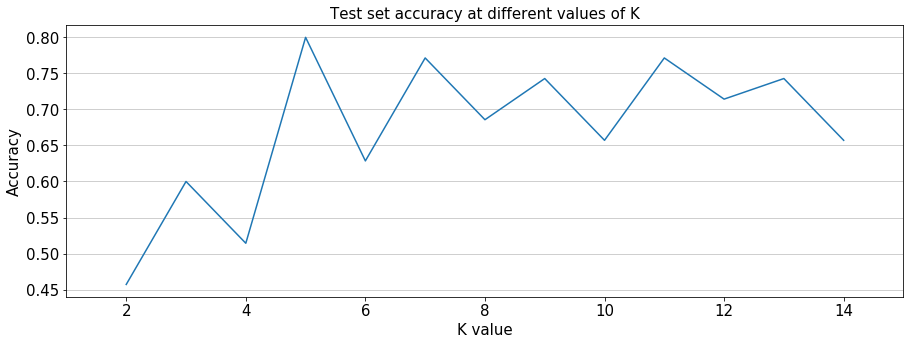

In [303]:
%matplotlib inline
plt.figure(figsize=[Ks,5])
klist = list(range(2, 15))
plt.plot(klist, mean_acc)
plt.xlim(min(klist)-1, max(klist)+1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('K value',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Test set accuracy at different values of K',fontsize=15)
plt.show()

In [234]:
%%markdown
Our best score is well above the threshold set as success criteria in the beginning of the analysis.

Our best score is well above the threshold set as success criteria in the beginning of the analysis.


In [235]:
%%markdown
### Training with Logistic Regression, SVM and Decision Tree
Since our data has many different venue types the random selection process of creating train/test sets can have a large impact on the outcome of analysis. For this reason SVM, Decision Tree and Logistic Regression is executed 50 times with 10 different randomisation and 5 different test size.
This solution is somewhat similar to bootstrapping, though the consideration and the implementaion not the exact same.
In the output for every test set size the average accuracy is calculated from the 10 random test set generation. This helps reducing the effect of randomisation and accidental overfitting.

### Training with Logistic Regression, SVM and Decision Tree
Since our data has many different venue types the random selection process of creating train/test sets can have a large impact on the outcome of analysis. For this reason SVM, Decision Tree and Logistic Regression is executed 50 times with 10 different randomisation and 5 different test size.
This solution is somewhat similar to bootstrapping, though the consideration and the implementaion not the exact same.
In the output for every test set size the average accuracy is calculated from the 10 random test set generation. This helps reducing the effect of randomisation and accidental overfitting.


In [364]:
yhat_list_lr = []
accuracy_lr = []
max_accuracy_lr = 0
n_for_max_lr = 0

yhat_list_svm = []
accuracy_svm = []
max_accuracy_svm = 0
n_for_max_svm = 0

yhat_list_dt = []
accuracy_dt = []
max_accuracy_dt = 0
n_for_max_dt = 0
import random
n = 0
for i in range(0, 5):
    accuracy_lr_size = []
    for j in range(0, 10):
        test_size = 0.1 + i/10 
        random_state = random.randint(1, 1000)
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_size, random_state=random_state)

        # Logistic Regression
        LR = LogisticRegression(C=0.1, solver='newton-cg').fit(X_train,y_train)
        yhat_list_lr.append(LR.predict(X_test))
        accuracy_lr.append([metrics.accuracy_score(y_test, yhat_list_lr[n]), test_size])
        if (accuracy_lr[n][0] > max_accuracy_lr):
            max_accuracy_lr = accuracy_lr[n][0]
            n_for_max_lr = n
        #end if

        
        #SVM
        clf = svm.SVC(gamma='scale')
        clf.fit(X_train, y_train) 
        yhat_list_svm.append(clf.predict(X_test))
        accuracy_svm.append([metrics.accuracy_score(y_test, yhat_list_svm[n]), test_size])
        if (accuracy_svm[n][0] > max_accuracy_svm):
            max_accuracy_svm = accuracy_svm[n][0]
            n_for_max_svm = n
        #end if

        
        # Decision Tree
        dTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        dTree.fit(X_train,y_train)
        yhat_list_dt.append(dTree.predict(X_test))
        accuracy_dt.append([metrics.accuracy_score(y_test, yhat_list_dt[n]), test_size])
        if (accuracy_dt[n][0] > max_accuracy_dt):
            max_accuracy_dt = accuracy_dt[n][0]
            n_for_max_dt = n
        #end if
        
        n += 1
    #end for
#end for
print("Logistic Regression------------------")
print("Best accuracy: {x}".format(x=max_accuracy_lr))
df_lr = pd.DataFrame(accuracy_lr, columns= ['average_accuracy', 'test_size'])
print(df_lr.groupby('test_size').mean())
print("SVM------------------")
print("Best accuracy: {x}".format(x=max_accuracy_svm))
df_svm = pd.DataFrame(accuracy_svm, columns= ['average_accuracy', 'test_size'])
print(df_svm.groupby('test_size').mean())
print("Decision Tree------------------")
print("Best accuracy: {x}".format(x=max_accuracy_dt))
df_dt = pd.DataFrame(accuracy_dt, columns= ['average_accuracy', 'test_size'])
print(df_dt.groupby('test_size').mean())

Logistic Regression------------------
Best accuracy: 0.8333333333333334
           average_accuracy
test_size                  
0.1                0.683333
0.2                0.694286
0.3                0.666038
0.4                0.674286
0.5                0.671264
SVM------------------
Best accuracy: 0.9444444444444444
           average_accuracy
test_size                  
0.1                0.600000
0.2                0.640000
0.3                0.622642
0.4                0.637143
0.5                0.619540
Decision Tree------------------
Best accuracy: 0.8333333333333334
           average_accuracy
test_size                  
0.1                0.627778
0.2                0.628571
0.3                0.618868
0.4                0.648571
0.5                0.595402


list

In [349]:
avlr = df_lr.groupby('test_size').mean().reset_index()
avsvm = df_svm.groupby('test_size').mean().reset_index()
avdt = df_dt.groupby('test_size').mean().reset_index()


In [395]:
def get_box_plot(df):
    ts_columns = []
    ts_data = []
    dict_ts = {}
    for ts in df['test_size'].unique():
        ts_columns.append(pd.Series(ts.round(2)))
        ts_data.append(pd.Series(df[df['test_size']==ts]['average_accuracy']))
        dict_ts[ts.round(2)] = list(df[df['test_size']==ts]['average_accuracy'])
    df_boxplot = pd.DataFrame(dict_ts)
    return df_boxplot


Text(0.5, 1.0, 'Decision Tree\nTest set accuracy with different train set randomisations at given test set sizes')

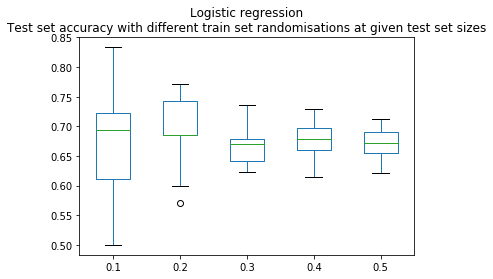

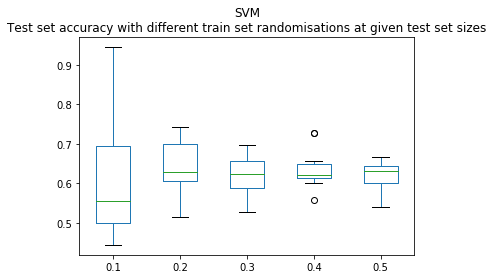

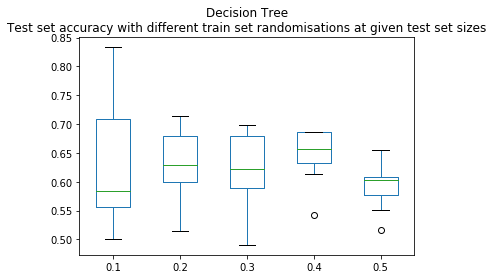

In [399]:
%matplotlib inline
ax1 = get_box_plot(df_lr).plot.box()
ax1.set_title('Logistic regression\nTest set accuracy with different train set randomisations at given test set sizes')

ax2 = get_box_plot(df_svm).plot.box()
ax2.set_title('SVM\nTest set accuracy with different train set randomisations at given test set sizes')

ax3 = get_box_plot(df_dt).plot.box()
ax3.set_title('Decision Tree\nTest set accuracy with different train set randomisations at given test set sizes')

In [400]:
%%markdown
# Conclusion

4 machine algorightm has been tested whether with their help we can predict from Foursquare data if a suburb is north or south of the Latte Line.
Due to the low number of elements in the samples we can consider the use of 90% of records in the training set overfitting, thus let's only concentrate on the rest.
K Neighbours passed the initially set 75% accuracy expectaions, Logistic regression was relatively close (considering the threshols was arbitrary), while SVM and Decision Tree were below pass mark.
This suggest that based on venue types it is possible to determine the location of a suburb.


# Conclusion

4 machine algorightm has been tested whether with their help we can predict from Foursquare data if a suburb is north or south of the Latte Line.
Due to the low number of elements in the samples we can consider the use of 90% of records in the training set overfitting, thus let's only concentrate on the rest.
K Neighbours passed the initially set 75% accuracy expectaions, Logistic regression was relatively close (considering the threshols was arbitrary), while SVM and Decision Tree were below pass mark.
This suggest that based on venue types it is possible to determine the location of a suburb.


In [302]:
%%markdown
## Final thoughts
It is important to note that based on venue types not only the 'Latte Line' quality can be determined since suburbs differ and resemble in many factors.
If we put the predictions on the map, we can see the sea side and the densly populated areas are normally marked with white, the remote areas with brown.
However, in many case there is no reason to think the given suburb shouls be considered on the other side of the line based on lifestyle, regardless the venues available.

UsageError: Cell magic `%%mardown` not found.


In [254]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=235)
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
prediction = neigh.predict(X)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Total set Accuracy: ", metrics.accuracy_score(y, prediction))

Train set Accuracy:  0.762589928057554
Test set Accuracy:  0.8
Total set Accuracy:  0.7701149425287356


In [295]:
df_y = pd.DataFrame(prediction)
df_y

,0
0,True
1,True
2,True
3,True
4,True
...,...
169,True
170,True
171,True
172,False


In [296]:
df_y['Suburb'] = ""
for i in range(0, len(df_y)):
    df_y.iat[i, 1] = df_labeled_venue_set.iat[i, 0]
df_y
df_y.columns = ['latte', 'Suburb']

In [297]:
df_y

,latte,Suburb
0,True,Alexandria
1,True,Arncliffe
2,True,Artarmon
3,True,Avalon Beach
4,True,Balgowlah
...,...,...
169,True,Wollstonecraft
170,True,Woollahra
171,True,Woolloomooloo
172,False,Yagoona


In [298]:
df_unlabeled = df_sydney_suburbs.copy()
del df_unlabeled['latte']
df_reconst = df_y.join(df_unlabeled.set_index('Suburb'), on='Suburb', how='inner')

In [299]:
df_reconst

,latte,Suburb,SSC_CODE_2016,Tot_P_M,Area sqkm,lat,long,density,radius
0,True,Alexandria,SSC10030,4214,3.5156,-33.909157,151.192128,1198.657413,1058
1,True,Arncliffe,SSC10086,5307,2.9429,-33.938236,151.145508,1803.323253,968
2,True,Artarmon,SSC10090,4654,2.5348,-33.809412,151.185761,1836.042291,898
3,True,Avalon Beach,SSC10111,4830,5.1313,-33.636504,151.329030,941.281936,1278
4,True,Balgowlah,SSC10153,3827,1.9590,-33.794442,151.260826,1953.547728,790
...,...,...,...,...,...,...,...,...,...
169,True,Wollstonecraft,SSC14359,3855,1.2007,-33.833204,151.195927,3210.627134,618
170,True,Woollahra,SSC14404,3370,1.2307,-33.861792,151.273342,2738.279028,626
171,True,Woolloomooloo,SSC14406,2275,0.3722,-33.871876,151.219222,6112.305212,344
172,False,Yagoona,SSC14453,8999,4.6180,-33.903791,151.017668,1948.679082,1212


In [300]:
coordinates = [[-34.001321, 151.235472],[-33.55000, 150.662457]]

latitude=-33.800000
longitude=151.00000
# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.PolyLine(coordinates).add_to(map_sydney)
for i in range(0, len(df_reconst)):
    if (df_reconst.iat[i, 0]):
        colour = 'white'
    else:
        colour = 'brown'
    #end if
    if(i%1==0):
        folium.Circle(
                [df_reconst.iat[i, 5], df_reconst.iat[i, 6]],
                radius=(1000*math.sqrt(df_reconst.iat[i, 4]/math.pi)),
                popup=df_reconst.iat[i, 1],
                color=colour,
                fill=True,
                fill_opacity=0.7).add_to(map_sydney)
    
    #folium.PolyLine(coordinates, color='green').add_to(map_sydney)
#end for

In [301]:
display(map_sydney)